In [33]:
import numpy as np
import therpy as tp
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
twopi = 2 * np.pi
import ipywidgets
from tqdm import tqdm_notebook as tqdm

# Cavity Mode Sum

In [151]:
# Function Definitions 
def step(x, x0):
    if x <= x0: return 0.0
    else: return 1.0
def istep(x, x0):
    if x >= x0: return 0.0
    else: return 1.0

step = np.vectorize(step, excluded='x0')
istep = np.vectorize(istep, excluded='x0')

def evens(x, t, n, T, G, L, k, w, c):
    return (t > n*T) * np.exp(- n * G * L) * np.exp(-G * x) * np.sin(k * x - w * (t - n * T)) * istep(x, c * (t - n * T))
def odds(x, t, n, T, G, L, k, w, c):
    return -1 * (t > n*T) * np.exp(- n * G * L) * np.exp(-G * (L - x)) * np.sin(- k * (x - L) - w * (t - n * T)) * step(x, L - c * (t - n * T))
def response(x, t, c=1, L=1, wl=1, dl=5, n=None):
    T = L/c
    k = twopi / wl
    w = twopi * c / wl
    G = 1.0 / dl
    if n is None: n = int(float(t) / T) + 1
    return np.sum([evens(x, t, ni, T, G, L, k, w, c) for ni in range(0, n, 2)], axis=0) + np.sum([odds(x, t, ni, T, G, L, k, w, c) for ni in range(1, n, 2)], axis=0)
def response_density(x, t, c=1, L=1, wl=1, dl=5, n=None):
    return np.diff(response(x, t, c=c, L=L, wl=wl, dl=dl, n=n))

## Time Evolution

In [157]:
# Animate the build up 
c0 = 1.0
L = 1.0
wl0 = L / 3
dl0 = 4 * L

x = np.linspace(0.0, 1.0, 100)
def temp(t = 0.0):
    plt.plot(x, response(x, t, c0, L, wl0, dl0))
    plt.ylim([-10, 10])
    plt.xlim([0, 1])
    plt.show()
ip = ipywidgets.interact(temp,t=(0, 10.0, 0.01))

In [188]:
# Sonogram 
c = 15e-3
L = 100e-6
xlist = np.linspace(0, L, 100)
wl = 2 * L / 2
f = c / wl
omega = twopi * f
Ncycles = np.arange(0, 10, 0.02)
Gamma = omega / 20
tlist = Ncycles / f
dl = 2 * c / Gamma

movie = np.array([response_density(x=xlist, t=tlist[i], c=c, L=L, wl=wl, dl=dl) for i in tqdm(range(len(tlist)))]).T

# Fourier Transform 
klist = np.arange(0, 8 * twopi/L, 0.1 * twopi/L)
ft = np.array([tp.fourier_transform(xlist[1:], movie[:,i], klist)[1] for i in tqdm(range(len(tlist)))]).T

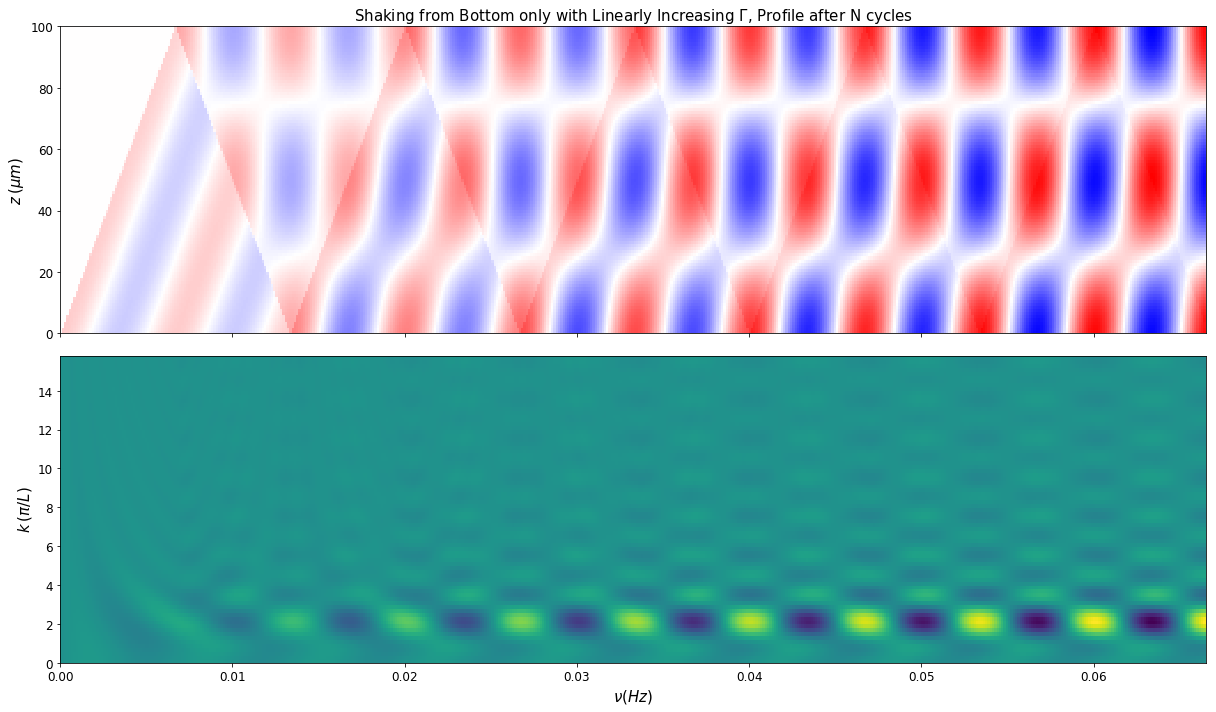

In [189]:
# Figure 
fig, ax = plt.subplots(figsize=[17, 10], sharex=True, nrows=2)
plt.sca(ax[0])
clim = np.max(np.abs(movie))
plt.pcolor(tlist, xlist*1e6, movie, cmap='bwr', vmin=-clim, vmax=clim)
plt.title(r'Shaking from Bottom only with Linearly Increasing $\Gamma$, Profile after N cycles', fontsize=15)
plt.ylabel(r'$z \: (\mu m)$', fontsize=15)
plt.yticks(fontsize=12)
plt.sca(ax[1])
plt.pcolor(tlist, klist / (np.pi/L), np.real(ft),)
plt.xlabel(r'$\nu (Hz)$', fontsize=15)
plt.ylabel(r'$k \: (\pi/L)$', fontsize=15)
plt.xlim([0, None])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

## Sonogram vs Freq

In [176]:
# Sonogram 
c = 15e-3
L = 100e-6
xlist = np.linspace(0, L, 100)
flist = np.arange(2.5, 1000, 2.5)
Ncycles = 25
Gamma = flist / 1000 * 500

tlist = Ncycles / flist
dl = 2 * c / Gamma
wl = c / flist

movie = np.array([response_density(x=xlist, t=tlist[i], c=c, L=L, wl=wl[i], dl=dl[i]) for i in tqdm(range(len(flist)))]).T

# Fourier Transform 
klist = np.arange(0, 8 * twopi/L, 0.1 * twopi/L)
ft = np.array([tp.fourier_transform(xlist[1:], movie[:,i], klist)[1] for i in tqdm(range(len(flist)))]).T

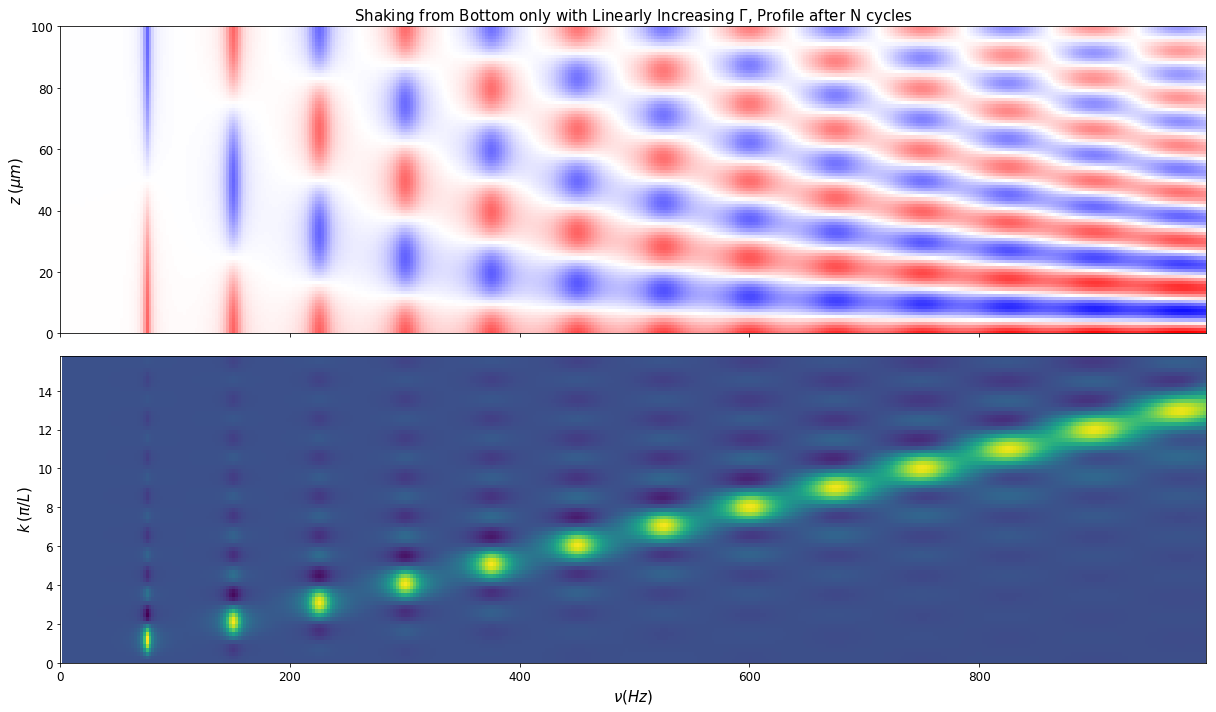

In [177]:
# Figure 
fig, ax = plt.subplots(figsize=[17, 10], sharex=True, nrows=2)
plt.sca(ax[0])
clim = np.max(np.abs(movie))
plt.pcolor(flist, xlist*1e6, movie, cmap='bwr', vmin=-clim, vmax=clim)
plt.title(r'Shaking from Bottom only with Linearly Increasing $\Gamma$, Profile after N cycles', fontsize=15)
plt.ylabel(r'$z \: (\mu m)$', fontsize=15)
plt.yticks(fontsize=12)
plt.sca(ax[1])
plt.pcolor(flist, klist / (np.pi/L), np.real(ft),)
plt.xlabel(r'$\nu (Hz)$', fontsize=15)
plt.ylabel(r'$k \: (\pi/L)$', fontsize=15)
plt.xlim([0, None])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [178]:
# Fourier Widths 
mode_num = np.arange(1, 13, 1)
lorentzian_fits = []
res_freq = 75

for m in mode_num: 
    guess = dict(x0 = [75 * m, 'Hz'], gamma = [0.25 * 75 * m, 'Hz'], amp=1, offset=0)
    cf = tp.curve_fit(tp.lorentzian, guess, flist, np.real(ft[m*5, :]), plot=False, info=False)
    lorentzian_fits.append(cf)

plt.figure()
plt.plot([f['x0'] for f in lorentzian_fits], [abs(f['gamma']*twopi) for f in lorentzian_fits])
plt.plot(flist, Gamma)

def temp(test=1):
    lorentzian_fits[test-1].plot()
    plt.show()

ipywidgets.interact(temp, test=(1, len(mode_num)))

<function __main__.temp>

In [179]:
# Fourier Widths 
mode_num = np.arange(1, 13, 1)
lorentzian_fits = []
res_freq = 75

for m in mode_num: 
    guess = dict(x0 = [75 * m, 'Hz'], gamma = [0.25 * 75 * m, 'Hz'], amp=1, offset=0)
    cf = tp.curve_fit(tp.lorentzian, guess, flist, flist * np.real(ft[m*5, :]), plot=False, info=False)
    lorentzian_fits.append(cf)

plt.figure()
plt.plot([f['x0'] for f in lorentzian_fits], [abs(f['gamma']*twopi) for f in lorentzian_fits])
plt.plot(flist, Gamma)

def temp(test=1):
    lorentzian_fits[test-1].plot()
    plt.show()

ipywidgets.interact(temp, test=(1, len(mode_num)))

<function __main__.temp>

## Time Evoluation

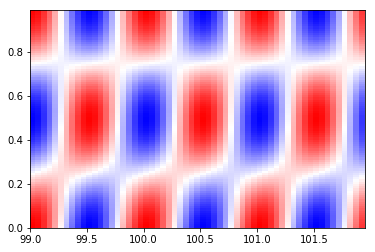

In [26]:
t = np.arange(99, 102, 0.05)
movie = np.array(np.diff([response(x, t=ti) for ti in t])).T
plt.pcolor(t, x[0:-1], movie, cmap='bwr')

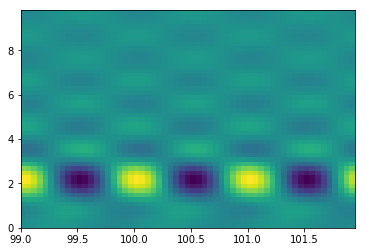

In [27]:
ks = np.pi/L
klist = np.arange(0, 5*twopi/L, 0.1*twopi/L)
ft = np.array([np.real(tp.fourier_transform(x[0:-1], movie[:,i], k=klist)[1]) for i in range(len(t))]).T
plt.pcolor(t,klist/ks,ft)

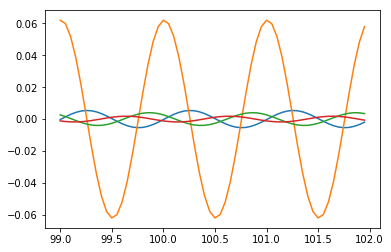

In [24]:
plt.plot(t, ft[5,:])
plt.plot(t, ft[10,:])
plt.plot(t, ft[15,:])
plt.plot(t, ft[20,:])

In [25]:
def fitfun(t, f=1, phase=0, amp=1,):
    return np.cos(twopi*f*t + phase) * amp 

cf1 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[ 5,:], info=True)
cf2 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[10,:], info=True)
cf3 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[15,:], info=True)
cf3 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[20,:], info=True)

       FitValue      FitError Units  Guess  LowerBound  UpperBound     FitError%
f      1.000000  2.251491e-11  None      1        -inf         inf  2.251491e-09
phase  1.510395  1.420948e-08  None      0        -inf         inf  9.407789e-07
amp   -0.005392  6.649975e-13  None      1        -inf         inf  1.233258e-08
       FitValue      FitError Units  Guess  LowerBound  UpperBound     FitError%
f      1.000000  8.168724e-12  None      1        -inf         inf  8.168724e-10
phase -0.051216  5.158779e-09  None      0        -inf         inf  1.007261e-05
amp    0.062038  2.734021e-12  None      1        -inf         inf  4.407029e-09
       FitValue      FitError Units  Guess  LowerBound  UpperBound     FitError%
f      1.000000  5.349637e-11  None      1        -inf         inf  5.349637e-09
phase  0.848864  3.374673e-08  None      0        -inf         inf  3.975517e-06
amp    0.004009  1.159992e-12  None      1        -inf         inf  2.893710e-08
       FitValue      FitErro